In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from Bio import SeqIO
from collections import defaultdict
import matplotlib.patches as patches


In [2]:
def parse_fasta_and_interleaved_phy(fasta_file, phy_file):
    """
    Parses a FASTA file for sequence descriptions and an interleaved PHYLIP file for sequences,
    assuming both files contain the sequences in the same order.

    :param fasta_file: Path to the FASTA file.
    :param phy_file: Path to the interleaved PHYLIP file.
    :return: A list of tuples, each containing a sequence description from the FASTA file
             and its corresponding sequence from the PHYLIP file.
    """
    # Parse the FASTA file for descriptions
    descriptions = [record.description for record in SeqIO.parse(fasta_file, "fasta")]
    
    # Initialize variables for parsing the PHYLIP file
    sequences = [''] * len(descriptions)  # Pre-initialize list to hold concatenated sequences
    seq_index = 0  # Index to keep track of the current sequence being concatenated

    with open(phy_file, 'r') as file:
        # First line contains the number of sequences and sequence length, which can be ignored here
        num_sequences, sequence_length = map(int, file.readline().strip().split())
        
        # Verify the number of sequences matches
        if num_sequences != len(descriptions):
            raise ValueError("The number of sequences in the FASTA and PHYLIP files does not match.")
        
        for line in file:
            line = line.strip()
            if line:  # Ignore empty lines
                # Extract the sequence part (after the first block of sequences, identifiers are not included)
                if seq_index < num_sequences:
                    # For the first block of sequences, ignore the first 10 characters (sequence identifier)
                    sequences[seq_index] += line[10:].strip()
                else:
                    # After the first block, directly concatenate sequence data
                    sequences[seq_index % num_sequences] += line.strip()
                seq_index += 1

    # Combine descriptions with sequences
    combined_data = list(zip(descriptions, sequences))
    return combined_data



In [85]:
def categorize_sample(sample_type):
    """
    Categorize the sample type into one of the four specified categories.
    """
    if '1alt' in sample_type:
        return '1alt_1'
    elif '1Malt' in sample_type:
        return '1alt_2'
    elif '1pri' in sample_type:
        return '1pri'
    elif 'altT' in sample_type or 'altF' in sample_type:
        return '2alt'
    elif 'priT' in sample_type or 'priF' in sample_type:
        return '2pri'
    return None

In [86]:
def prepare_data(fasta_file, phy_file):
    sequences = parse_fasta_and_interleaved_phy(fasta_file, phy_file)
    # Combine data
    data = []
    for desc, seq in sequences:
        _, _, sample_type,  position, _ = desc.split('_')
        category = categorize_sample(sample_type)
        if category and position is not None:  # Ensure we have both category and position
            data.append((desc, seq, category, position))
    
    # Sort by genomic position
    data.sort(key=lambda x: x[3])
    return data



In [87]:
def count_mismatches(seq1, seq2):
    """
    Count the number of mismatches between two sequences.
    Assumes both sequences are of equal length.

    :param seq1: First sequence as a string.
    :param seq2: Second sequence as a string.
    :return: Count of mismatches between seq1 and seq2.
    """
    # Check if sequences are of the same length to ensure accurate comparison
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of the same length for comparison.")
    
    # Count mismatches
    mismatches = sum(1 for base1, base2 in zip(seq1, seq2) if base1 != base2)
    mismatch_Rate = mismatches/len(seq1)
    return mismatches


In [120]:
def draw_curved_edges_corrected(ax, G, pos, curvature_scale=1.5):
    for edge in G.edges(data=True):
        node1, node2, d = edge
        if node1 not in pos or node2 not in pos:
            continue  # Skip edges where one or both nodes are excluded from the current visualization
        x1, y1 = pos[node1]
        x2, y2 = pos[node2]
        
        # Only draw curved edges for intra-row connections
        if y1 == y2:
            # Curvature scale affects the "height" of the arc
            dx = x2 - x1
            arc_height = abs(dx) / curvature_scale /20  # Control the height of the arc

            # Calculate mid-point for placing the arc
            mid_x = (x1 + x2) / 2
            mid_y = y1  # Keep the arc aligned with the row's y-coordinate

            # Determine control points for Bezier curve to simulate an arc
            ctrl1_x = mid_x
            ctrl1_y = mid_y + arc_height  # Control point 1 (for height of the arc)
            ctrl2_x = mid_x
            ctrl2_y = mid_y + arc_height  # Control point 2 (identical to ctrl1 for a symmetric arc)

            # Draw the Bezier curve
            verts = [(x1, y1), (ctrl1_x, ctrl1_y), (ctrl2_x, ctrl2_y), (x2, y2)]
            codes = [patches.Path.MOVETO, patches.Path.CURVE4, patches.Path.CURVE4, patches.Path.CURVE4]
            path = patches.Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor=d['color'])
            patch.set_linestyle(d['linestyle'])
            ax.add_patch(patch)
        else:
            # Draw a straight line for inter-row connections
            plt.plot([x1, x2], [y1, y2], color=d['color'], lw=1, linestyle=d['linestyle'])

In [125]:
data = prepare_data("../treeBuilding/mCanLor/combined_genes_IGH.fasta", "../treeBuilding/mCanLor/combined_genes_IGH.phy")
parsed_data = [(desc, seq, category, position) for desc, seq, category, position in data if category in ['1alt_1']]
parsed_data.sort(key=lambda x: int(x[3]))
x_min1 = min([int(position) for desc, seq, category, position  in parsed_data])
x_max1 = max([int(position) for desc, seq, category, position  in parsed_data])
parsed_data = [(desc, seq, category, position) for desc, seq, category, position in data if category in ['1alt_2']]
parsed_data.sort(key=lambda x: int(x[3]))
x_min2 = min([int(position) for desc, seq, category, position  in parsed_data])
x_max2 = max([int(position) for desc, seq, category, position  in parsed_data])

In [126]:
parsed_data = []
for desc, seq, category, position in data:
    if '1alt_1' in category:
        newcat = '1alt'
        newpos = int(position) 
    elif '1alt_2' in category:
        newcat = '1alt'
        newpos = int(position) + x_max1
    else:
        newcat = category
        newpos = int(position)
    parsed_data.append((desc, seq, newcat, newpos))
         


In [127]:
parsed_data = [(desc, seq, category, position) for desc, seq, category, position in parsed_data if category in ['2alt', '1alt']]


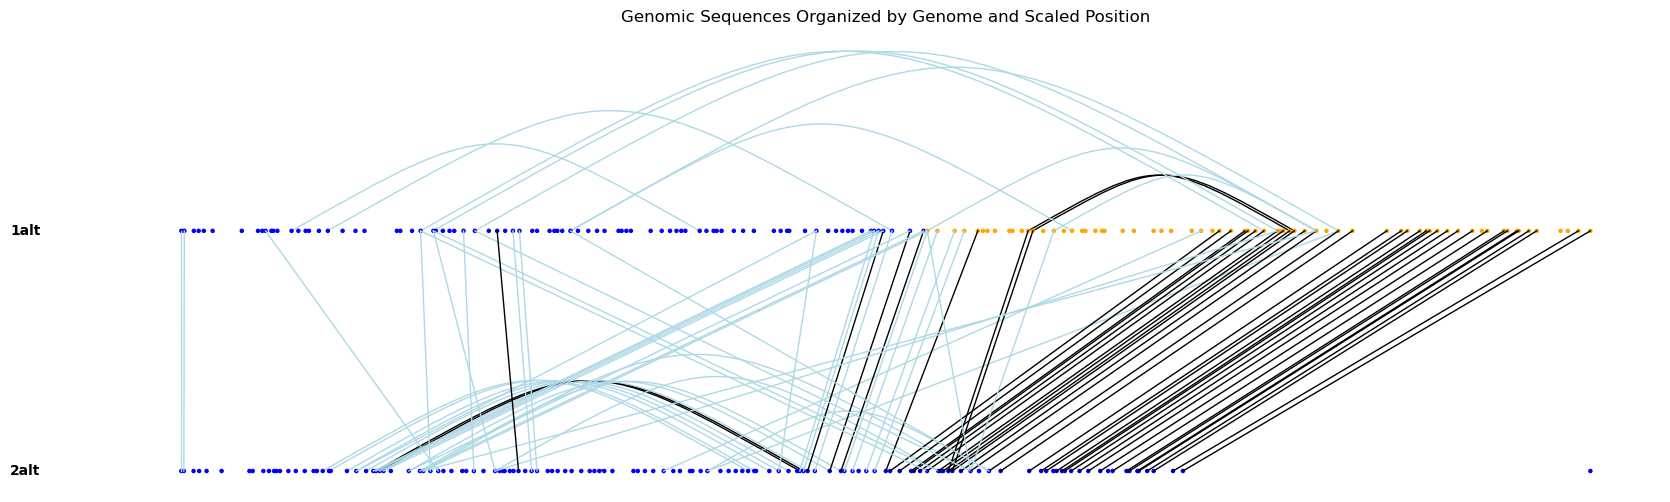

In [128]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
G = nx.Graph()

# Add nodes with additional attributes
node_colors = []

for desc, seq, category, position in parsed_data:
    if '1alt' in category and position > x_max1:
        G.add_node(desc, sequence=seq, category=category, position=position)
        node_colors.append('orange')
    else:
        G.add_node(desc, sequence=seq, category=category, position=position)
        node_colors.append('blue')
            
# Group nodes by category and sort by position within each group
grouped_nodes = defaultdict(list)
for desc, _, category, position in parsed_data:
    grouped_nodes[category].append((desc, position))
for category in grouped_nodes:
    grouped_nodes[category].sort(key=lambda x: x[1])  # Sort by position

# Assign scaled positions to nodes
pos = {}
genome_labels = {}
y = 0  # Initial y position
y_offset = -2  # Adjust y offset for each category row
for category, nodes in grouped_nodes.items():
    x_positions = [int(position) for _, position in nodes]
    scaled_x_positions = [float(i - min(x_positions)) / (max(x_positions) - min(x_positions)) * 100 for i in x_positions]
    for (desc, _), scaled_x in zip(nodes, scaled_x_positions):
        pos[desc] = (scaled_x, y)
    genome_labels[category] = (min(scaled_x_positions) - 10, y)  # Position label to the left of the first node
    y += y_offset  # Move to the next row (y position) for each category


# Add edges based on mismatch count, identifying intra-row connections
for i, (desc1, seq1, category1, _) in enumerate(parsed_data):
    for desc2, seq2, category2, _ in parsed_data[i+1:]:
        mismatch = count_mismatches(seq1, seq2)
        # Add edges based on mismatches
        if mismatch == 0:
            G.add_edge(desc1, desc2, color='black', weight=mismatches,  linestyle='solid', intra_row=(category1 == category2))
        elif mismatch <= 2:
            G.add_edge(desc1, desc2, color='lightblue', weight=mismatches, linestyle='solid', intra_row=(category1 == category2))


# Visualization
plt.figure(figsize=(20, 6))  # Adjust figure size as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=node_colors)

# Draw labels
#nx.draw_networkx_labels(G, pos)
ax = plt.gca()
draw_curved_edges_corrected(ax, G, pos)

# Add genome labels
for genome, label_pos in genome_labels.items():
    plt.text(label_pos[0], label_pos[1], genome, horizontalalignment='right', verticalalignment='center', fontsize=10, fontweight='bold', color='black')



plt.title("Genomic Sequences Organized by Genome and Scaled Position")
plt.axis('off')  # Turn on the axis for better layout understanding
plt.show()